In [ ]:
#@title Sentiment Analysis of Twitter Data using VADER


In [53]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [ ]:
#@title Data Exploration


In [2]:
from google.colab import files 
uploaded = files.upload()
import io 
tweets_text = pd.read_csv(io.BytesIO(uploaded['election_day_tweets.csv'])) 

Saving election_day_tweets.csv to election_day_tweets.csv


In [3]:
#Shape of the Tweet Dataset
print("Shape of the Tweet Dataset=",tweets_text.shape)

Shape of the Tweet Dataset= (397629, 34)


In [4]:
#Twitter Data Display
tweets_text.head()

,text,created_at,geo,lang,place,coordinates,user.favourites_count,user.statuses_count,user.description,user.location,user.id,user.created_at,user.verified,user.following,user.url,user.listed_count,user.followers_count,user.default_profile_image,user.utc_offset,user.friends_count,user.default_profile,user.name,user.lang,user.screen_name,user.geo_enabled,user.profile_background_color,user.profile_image_url,user.time_zone,id,favorite_count,retweeted,source,favorited,retweet_count
0,.@Lawrence @HillaryClinton Two first @SenSchu...,2016-11-08 04:04:37,NaN,en,NaN,NaN,18882,26939,"The Specialist, Copyrighted TX0008044160 #Surv...",WorldWide 80Million StealthRUs,22729901,2009-03-04 03:55:45,False,False,https://t.co/rKXNF1G270,374,86551,False,-28800.0,2674,False,Phillip Sheppard,en,PSheppardTV,True,131516,http://pbs.twimg.com/profile_images/7878871945...,America/Los_Angeles,795839414735732737,11,False,Twitter for Android,False,8
1,My @latimesopinion op-ed on historic #Californ...,2016-11-08 04:08:10,NaN,en,NaN,NaN,8,4841,Hoover Institution research fellow; https://t....,"Palo Alto, California",794779346,2012-08-31 22:13:27,False,False,https://t.co/K2fl294qFp,91,1689,False,-28800.0,344,False,Bill Whalen,en,hooverwhalen,True,C0DEED,http://pbs.twimg.com/profile_images/6514470051...,Pacific Time (US & Canada),795840310597193728,3,False,Twitter Web Client,False,4
2,#Senate Wisconsin Senate Preview: Johnson vs. ...,2016-11-08 04:11:35,NaN,en,NaN,NaN,728,160390,US SENATE NEWS FEED. The U.S. Senate is the w...,USA,190890578,2010-09-15 02:41:11,False,False,NaN,798,14726,False,-32400.0,13974,False,Quorum Call,en,QuorumCall,False,473969,http://pbs.twimg.com/profile_images/6155877017...,Alaska,795841168621719552,0,False,dlvr.it,False,0
3,If Rubio Wins and #Trump Loses in #Florida... ...,2016-11-08 04:12:16,NaN,en,NaN,NaN,0,18105,The most trending Marco Rubio news as collecte...,Washington DC,3175968009,2015-04-17 09:59:55,False,False,http://t.co/TbC8SzlTVN,57,121,False,NaN,96,True,Marco Rubio Trends,nl,Rubiolizer,False,C0DEED,http://pbs.twimg.com/profile_images/5890065307...,NaN,795841341146234880,0,False,Lead Stories Feed Publisher,False,0
4,#Senate Wisconsin Senate Preview: Johnson vs. ...,2016-11-08 04:16:20,NaN,en,NaN,NaN,4722,247322,News & #ALERTS. We are a large group of proud ...,24hr Live HD Stream Broadcast,2836839353,2014-10-19 04:50:02,False,False,https://t.co/ceRinWzb9I,288,17479,False,-18000.0,2291,False,NTA✪NEWS ROOM™,en,NoThiefs,False,1B95E0,http://pbs.twimg.com/profile_images/7971276617...,Eastern Time (US & Canada),795842365881782272,0,False,IFTTT,False,0


In [5]:
#Moving only Twitter Text to a separate dataframe
df = pd.DataFrame(tweets_text,columns =['text'])
df.head()

,text
0,.@Lawrence @HillaryClinton Two first @SenSchu...
1,My @latimesopinion op-ed on historic #Californ...
2,#Senate Wisconsin Senate Preview: Johnson vs. ...
3,If Rubio Wins and #Trump Loses in #Florida... ...
4,#Senate Wisconsin Senate Preview: Johnson vs. ...


In [6]:
#Checking for Null Values one by one for all files
df.isnull().sum()

text    0
dtype: int64

In [7]:
#Dropping the Duplicate Values if Any
df.drop_duplicates(inplace= True)

In [8]:
#Shape of File After Dropping Duplicates
print(" Shape of File after dropping duplicates: ",df.shape)

 Shape of File after dropping duplicates:  (393764, 1)


In [81]:
#@title Data Preprocessing


In [9]:
#Importing Necessary Libraries for Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re,string
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [10]:
#Stopwords

In [11]:
#Downloading Stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
#Load English Stop Words
stopword = stopwords.words('english')
print("Stopwords:",stopword)

Stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so'

In [13]:
#Tweet Clean Function
def tweet_clean(twee):
    #Remove URL
    twee = re.sub(r'https?://\S+|www\.\S+', " ", twee)

    #Remove Punctuation
    twee= re.sub(r'[^\w\s\d]',' ',twee)

    #Remove Digits
    twee = re.sub(r'\d+', ' ', twee)

    #Remove HTML tags
    twee = re.sub('r<.*?>',' ', twee)

    #Remove Stop Words 
    twee = twee.split()
    
    twee = " ".join([word for word in twee if not word in stopword])
    twee1 = twee.lower()

    return twee1

In [14]:
#Applying Tweet Clean Function to Both Files
df['text'] = df['text'].astype(str).apply(lambda x: tweet_clean(x))

In [15]:
#Updated Sentiment Data
df

,text
0,lawrence hillaryclinton two first senschumer t...
1,my latimesopinion op ed historic california se...
2,senate wisconsin senate preview johnson vs fei...
3,if rubio wins trump loses florida hillaryclint...
4,senate wisconsin senate preview johnson vs fei...
...,...
397624,today got stressed election
397625,my views election tune queceracera electionday...
397626,la disinvolta trasformazione da blog cazzi amp...
397627,one favorite shots take casting ballot nostalg...


In [18]:
#Adding Labels to the Dataset
Dem_Keywords = ['hillary', 'clinton','hillaryclinton', 'democrats','voteblue', 'Democratic', 'kaine', 'tim','timkaine','billclinton','schumer','pelosi','nancy','nancypelosi',
                    'hassan','cortezmasto','cortez','masto','harryreid','harry','reid','tammyduckworth','tammy','duckworth','michael','bennet','michaelbennet','barbara','boxer',
                    'barbaraboxer','kamala','harris','kamalaharris','richard','blumenthal','richardblumenthal','brianschatz','brian','schatz','barbaramikulski','barbara','mikulski',
                    'chuckschumer','chuck','schumer','ronwyden','ron','wyden','patrickleahy','patrick','leahy','patty','murray','pattymurray','roncrumpton','ron','crumpton','ray',
                    'metcalfe','raymetcalfe','annkirkpatrick','ann','kirkpatrick','connereldridge','conner','eldridge','loretta','sanchez','lorettasanchez','patrick','murphy',
                    'patrickmurphy','jimbarksdale','jim','barksdale','jerrysturgill','jerry','sturgill','evanbayh','evan','bayh','pattyjudge','patty','judge','patrickwiesner',
                    'patrick','wiesner','jimgray','jim','gray','fostercampbell','foster','campbell','chrisvanhollen','chris','van','hollen','jason','kander','jasonkander',
                    'deborahross','deborah','ross','eliot','glassheim','eliotglassheim','tedstrickland','ted','strickland','mike','workman','mikeworkman','katiemcGinty','katie',
                    'mcGinty','thomas','dixon','thomasdixon','jaywilliams','jay','williams','mistyksnow','misty','snow','russ','feingold','russfeingold']

Rep_Keywords = ['trump', 'donald','donaldtrump','republicans','votered', 'americafirst', 'pence', 'mike','mikepence','melaniatrump', 'russia', 'mitch','lisa','murkowski',
                  'lisamurkowski','john','mccain','johnmccain','marco','rubio','marcorubio','johnny','isakson','johnnyisakson','mark','kirk','markkirk','dan','coats','dancoats',
                  'chuck','grassley','chuckgrassley','rand','paul','randpaul','david','vitter','davidvitter','roy','blunt','royblunt','kellyayotte','kelly','ayotte','richard',
                  'burr','richardburr','robportman','rob','portman','todd','young','toddyoung','john','kennedy','johnkennedy','pattoomey','pat','tommey','ron','johnson','ronjohnson',
                  'richardshelby','richard','shelby','john','boozman','johnboozman','mikecrapo','mike','crapo','jerry','moran','jerrymoran','johnhoeven','john','hoeven',
                  'jameslankford','james','lankford','timscott','tim','scott','johnthune','john','thune','mikelee','mike','lee','darrylglenn','darryl','glenn','dan','carter',
                  'dancarter','johncarroll','john','carroll','kathyszeliga','kathy','szeliga','joe','heck','joeheck','wendy','long','wendylong','mark','callahan','markcallahan',
                  'scott','milne','scottmilne','chris','vance','chrisvance']
  
def assign_label(i):
  Dem = any(ele in i for ele in Dem_Keywords)
  Rep = any(ele in i for ele in Rep_Keywords)
  if Dem == True:
    return 'Democrat'
  if Rep == True:
    return 'Republican'
  else:
    return 'Neutral'

In [19]:
#Adding Labels to the Dataset
df['Labels'] = df['text'].apply(assign_label)

In [19]:
#Label Distribution
df['Labels'].value_counts()

Neutral       213337
Democrat      120042
Republican     60385
Name: Labels, dtype: int64

In [20]:
#Labelled Dataset
df.head()

,text,Labels
0,lawrence hillaryclinton two first senschumer t...,Democrat
1,my latimesopinion op ed historic california se...,Democrat
2,senate wisconsin senate preview johnson vs fei...,Democrat
3,if rubio wins trump loses florida hillaryclint...,Democrat
4,senate wisconsin senate preview johnson vs fei...,Democrat


In [48]:
#Forming two dataframes based on Labels
df_dem = df[df['Labels'] == 'Democrat']
df_rep = df[df['Labels'] == 'Republican']

In [49]:
#Dataframe representing the Democrat label
df_dem1 = df_dem.reset_index(drop=True)
df_dem1

,text,Labels
0,lawrence hillaryclinton two first senschumer t...,Democrat
1,my latimesopinion op ed historic california se...,Democrat
2,senate wisconsin senate preview johnson vs fei...,Democrat
3,if rubio wins trump loses florida hillaryclint...,Democrat
4,senate wisconsin senate preview johnson vs fei...,Democrat
...,...,...
120037,on election day voters use electronic optical ...,Democrat
120038,sára best foot forward election day did vote e...,Democrat
120039,this all time election,Democrat
120040,i felt left i rocking cool sticker ivotedearly...,Democrat


In [50]:
#Dataframe representing the Republican label
df_rep1 = df_rep.reset_index(drop=True)
df_rep1

,text,Labels
0,bob day honest person senate patterson loss se...,Republican
1,she done america please vote realdonaldtrump m...,Republican
2,senate sen mark warner speak odu veterans day ...,Republican
3,senate sen mark warner speak odu veterans day ...,Republican
4,hat tip peterrobinson adding senate take ricoc...,Republican
...,...,...
60380,eyyyyy hilaryyy haddini bil başkan trump election,Republican
60381,the washington family wants get vote today ele...,Republican
60382,no offense trumpistas i hope donald loses toda...,Republican
60383,souljaboy says guy said fuck troops you probab...,Republican


In [141]:
#@title Sentiment Analysis


In [51]:
#Installing vaderSentiment
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [52]:
#Importing SentimentIntensityAnalyzer() that takes a string and returns a dictionary of scores in each of four categories
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [55]:
#Defining function for calculating the scores
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [56]:
#Scoring the texts for democrats
df_dem1['Sentiment_Polarity'] = df_dem1['text'].apply(sentiment_analyzer_scores)
df_dem1.head()

,text,Labels,Sentiment_Polarity
0,lawrence hillaryclinton two first senschumer t...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,my latimesopinion op ed historic california se...,Democrat,"{'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'comp..."
2,senate wisconsin senate preview johnson vs fei...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,if rubio wins trump loses florida hillaryclint...,Democrat,"{'neg': 0.153, 'neu': 0.6, 'pos': 0.247, 'comp..."
4,senate wisconsin senate preview johnson vs fei...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [57]:
#Making a new column with the compound score
df_dem1['compound']  = df_dem1['Sentiment_Polarity'].apply(lambda x: x['compound'])
df_dem1

,text,Labels,Sentiment_Polarity,compound
0,lawrence hillaryclinton two first senschumer t...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,my latimesopinion op ed historic california se...,Democrat,"{'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'comp...",0.4939
2,senate wisconsin senate preview johnson vs fei...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,if rubio wins trump loses florida hillaryclint...,Democrat,"{'neg': 0.153, 'neu': 0.6, 'pos': 0.247, 'comp...",0.3400
4,senate wisconsin senate preview johnson vs fei...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
...,...,...,...,...
120037,on election day voters use electronic optical ...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
120038,sára best foot forward election day did vote e...,Democrat,"{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'comp...",0.6369
120039,this all time election,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
120040,i felt left i rocking cool sticker ivotedearly...,Democrat,"{'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'comp...",0.3182


In [58]:
#Assigninig sentiment labels positive, negative & neutral
def func(c):
  if c >= 0.05:
    return 'positive'
  elif c <= -0.05:
    return 'negative'
  else:
    return 'neutral'
    

df_dem1['Scores'] = df_dem1['compound'].apply(func)
df_dem1

,text,Labels,Sentiment_Polarity,compound,Scores
0,lawrence hillaryclinton two first senschumer t...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,my latimesopinion op ed historic california se...,Democrat,"{'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'comp...",0.4939,positive
2,senate wisconsin senate preview johnson vs fei...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
3,if rubio wins trump loses florida hillaryclint...,Democrat,"{'neg': 0.153, 'neu': 0.6, 'pos': 0.247, 'comp...",0.3400,positive
4,senate wisconsin senate preview johnson vs fei...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
...,...,...,...,...,...
120037,on election day voters use electronic optical ...,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
120038,sára best foot forward election day did vote e...,Democrat,"{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'comp...",0.6369,positive
120039,this all time election,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
120040,i felt left i rocking cool sticker ivotedearly...,Democrat,"{'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'comp...",0.3182,positive


In [59]:
#Scoring the texts for republicans
df_rep1['Sentiment_Polarity'] = df_rep1['text'].apply(sentiment_analyzer_scores)
df_rep1.head()

,text,Labels,Sentiment_Polarity
0,bob day honest person senate patterson loss se...,Republican,"{'neg': 0.198, 'neu': 0.517, 'pos': 0.284, 'co..."
1,she done america please vote realdonaldtrump m...,Republican,"{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp..."
2,senate sen mark warner speak odu veterans day ...,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,senate sen mark warner speak odu veterans day ...,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,hat tip peterrobinson adding senate take ricoc...,Republican,"{'neg': 0.0, 'neu': 0.61, 'pos': 0.39, 'compou..."


In [60]:
#Making a new column with the compound score
df_rep1['compound']  = df_rep1['Sentiment_Polarity'].apply(lambda x: x['compound'])
df_rep1

,text,Labels,Sentiment_Polarity,compound
0,bob day honest person senate patterson loss se...,Republican,"{'neg': 0.198, 'neu': 0.517, 'pos': 0.284, 'co...",0.2500
1,she done america please vote realdonaldtrump m...,Republican,"{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp...",0.3182
2,senate sen mark warner speak odu veterans day ...,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,senate sen mark warner speak odu veterans day ...,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,hat tip peterrobinson adding senate take ricoc...,Republican,"{'neg': 0.0, 'neu': 0.61, 'pos': 0.39, 'compou...",0.7506
...,...,...,...,...
60380,eyyyyy hilaryyy haddini bil başkan trump election,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
60381,the washington family wants get vote today ele...,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
60382,no offense trumpistas i hope donald loses toda...,Republican,"{'neg': 0.304, 'neu': 0.561, 'pos': 0.136, 'co...",-0.3818
60383,souljaboy says guy said fuck troops you probab...,Republican,"{'neg': 0.353, 'neu': 0.647, 'pos': 0.0, 'comp...",-0.7964


In [61]:
#Assigninig sentiment labels positive, negative & neutral
df_rep1['Scores'] = df_rep1['compound'].apply(func)
df_rep1

,text,Labels,Sentiment_Polarity,compound,Scores
0,bob day honest person senate patterson loss se...,Republican,"{'neg': 0.198, 'neu': 0.517, 'pos': 0.284, 'co...",0.2500,positive
1,she done america please vote realdonaldtrump m...,Republican,"{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp...",0.3182,positive
2,senate sen mark warner speak odu veterans day ...,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
3,senate sen mark warner speak odu veterans day ...,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
4,hat tip peterrobinson adding senate take ricoc...,Republican,"{'neg': 0.0, 'neu': 0.61, 'pos': 0.39, 'compou...",0.7506,positive
...,...,...,...,...,...
60380,eyyyyy hilaryyy haddini bil başkan trump election,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
60381,the washington family wants get vote today ele...,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
60382,no offense trumpistas i hope donald loses toda...,Republican,"{'neg': 0.304, 'neu': 0.561, 'pos': 0.136, 'co...",-0.3818,negative
60383,souljaboy says guy said fuck troops you probab...,Republican,"{'neg': 0.353, 'neu': 0.647, 'pos': 0.0, 'comp...",-0.7964,negative


In [62]:
print('Sentence: '+ df_rep1['text'].loc[0])
print('Sentiment: ' +df_rep1['Scores'].loc[0])

Sentence: bob day honest person senate patterson loss senate
Sentiment: positive


In [63]:
print('Sentence: '+ df_rep1['text'].loc[60382])
print('Sentiment: ' +df_rep1['Scores'].loc[60382])

Sentence: no offense trumpistas i hope donald loses today by tremendous big league yuuuge margins election imwithher maga
Sentiment: negative


In [64]:
print('Sentence: '+ df_rep1['text'].loc[60380])
print('Sentiment: ' +df_rep1['Scores'].loc[60380])

Sentence: eyyyyy hilaryyy haddini bil başkan trump election
Sentiment: neutral


In [ ]:
#@title Visualizations


In [66]:
new = df_dem1.groupby('Scores').count()
x = list(new['compound'])
y = list(new.index)
tuple_list = list(zip(x,y))

df = pd.DataFrame(tuple_list, columns=['x','y'])
df['color'] = 'red'
df['color'][1] = 'grey'
df['color'][2] = 'green'

import plotly.graph_objects as go
fig = go.Figure(go.Bar(x=df['x'],y=df['y'],orientation ='h',marker={'color': df['color']}))
fig.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [67]:
new = df_rep1.groupby('Scores').count()
x = list(new['compound'])
y = list(new.index)
tuple_list = list(zip(x,y))

df = pd.DataFrame(tuple_list, columns=['x','y'])

df['color'] = 'red'
df['color'][1] = 'grey'
df['color'][2] = 'green'

import plotly.graph_objects as go
fig = go.Figure(go.Bar(x=df['x'],
                y=df['y'],
                orientation ='h',
                marker={'color': df['color']}))
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [68]:
df_dem1.shape, df_rep1.shape

((120042, 5), (60385, 5))

In [69]:
#Types of Scores 
df_dem1['Scores'].value_counts()

neutral     49337
positive    45260
negative    25445
Name: Scores, dtype: int64

In [70]:
#Types of Scores 
df_rep1['Scores'].value_counts()

positive    23063
neutral     22895
negative    14427
Name: Scores, dtype: int64

In [71]:
#Removing rows with "Neutral" score
Dem_Neutral = df_dem1[df_dem1['Scores'] == 'neutral']
cond=df_dem1['Scores'].isin(Dem_Neutral['Scores'])
df_dem1.drop(df_dem1[cond].index, inplace = True)
df_dem1.shape

(70705, 5)

In [72]:
#Removing rows with "Neutral" score
Rep_Neutral = df_rep1[df_rep1['Scores'] == 'neutral']
cond=df_rep1['Scores'].isin(Rep_Neutral['Scores'])
df_rep1.drop(df_rep1[cond].index, inplace = True)
df_rep1.shape

(37490, 5)

In [73]:
#Creating list of positive & negative scores
count = (df_dem1['Scores'] == 'positive').value_counts()
count

True     45260
False    25445
Name: Scores, dtype: int64

In [74]:
Pos_dem = count[1]
Neg_dem = count[0]
Pos_dem, Neg_dem

(45260, 25445)

In [75]:
#Creating list of positive & negative scores
count = (df_rep1['Scores'] == 'positive').value_counts()
count

True     23063
False    14427
Name: Scores, dtype: int64

In [76]:
Pos_rep = count[1]
Neg_rep = count[0]
Pos_rep, Neg_rep

(23063, 14427)

In [77]:
#Visualization showing Positive-Negative tweets for both Democrats & Republicans
Parties = ['Democrats', 'Republicans']
pos = [Pos_dem, Pos_rep]
neg = [Neg_dem, Neg_rep]

fig = go.Figure(data=[
    go.Bar(name='Positive', x=Parties, y=pos),
    go.Bar(name='Negative', x=Parties, y=neg)
])
fig.update_layout(barmode='group')
fig.show()

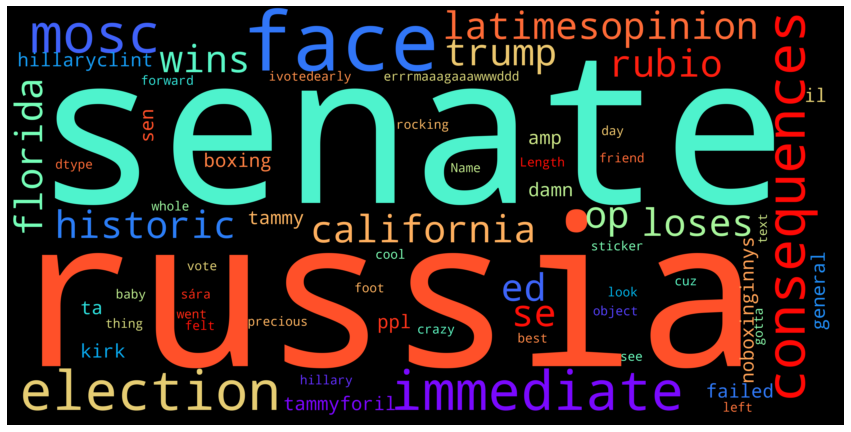

In [78]:
#Visualization showing the words associated with the tweets for Democrats 
from wordcloud import WordCloud
text = str(df_dem1.text)
wordcloud = WordCloud(max_font_size=100, max_words=500, scale=10, relative_scaling=.6, background_color="black", colormap = "rainbow").generate(text)

# Display the generated image:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

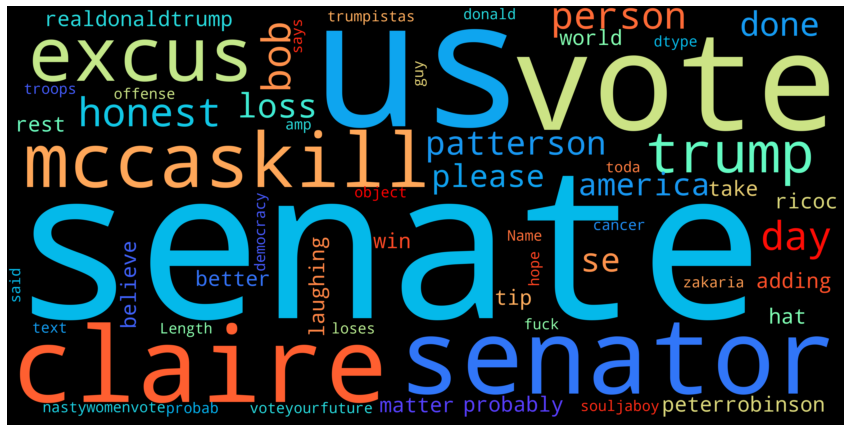

In [79]:
#Visualization showing the words associated with the tweets for Republicans 
text = str(df_rep1.text)
wordcloud = WordCloud(max_font_size=100, max_words=500, scale=10, relative_scaling=.6, background_color="black", colormap = "rainbow").generate(text)

# Display the generated image:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

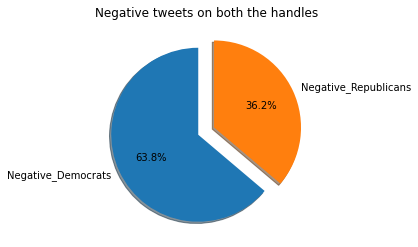

In [80]:
#Visualization showing the ratio of negative tweets for both Democrats & Republicans 
labels =  ['Negative_Democrats', 'Negative_Republicans'] 
sizes = neg
explode = (0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels = labels, autopct = '%1.1f%%', shadow = True, startangle=90)
ax1.set_title('Negative tweets on both the handles')
plt.show()

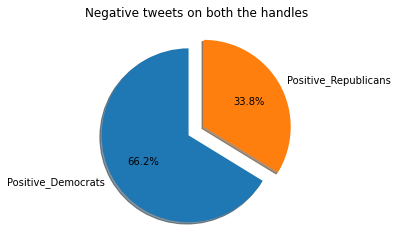

In [81]:
#Visualization showing the ratio of positive tweets for both Democrats & Republicans 
labels =  ['Positive_Democrats', 'Positive_Republicans'] 
sizes = pos
explode = (0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels = labels, autopct = '%1.1f%%', shadow = True, startangle=90)
ax1.set_title('Negative tweets on both the handles')
plt.show()